In [ ]:
cd drive/My\ Drive/facenet

/content/drive/My Drive/facenet


In [ ]:
!ls

lfw  lfw.tgz  siamese_xception.h5


In [ ]:
from tensorflow.keras.utils import Sequence, multi_gpu_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Concatenate, Lambda, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [ ]:
import numpy as np
class TripletImageLoader(tf.keras.utils.Sequence):
    def __init__(self, df, preprocess_function, img_shape, batchSize = 16, flip=False):
        self.files = df['image'].values
        self.batchSize = batchSize
        self.y = df['label'].values
        self.N = len(self.y)
        self.shape = img_shape
        self.function = preprocess_function
        self.flip = flip
        
    def load_image(self, file):
        img = image.load_img( '{}'.format(file),target_size=(self.shape[0],self.shape[1]))
        img = image.img_to_array(img)
        img = self.function(img)
        # img = tf.keras.backend.resize_images(img,self.shape[1],self.shape[0],data_format='channels_last')
        if self.flip:
            if np.random.randint(0, 2): # do flippings in 50% of the time
                img = img[:, ::-1, :]
        return img

    #gets the number of batches this generator returns
    def __len__(self):
        l,rem = divmod(self.N, self.batchSize)
        return (l + (1 if rem > 0 else 0))
    
    #shuffles data on epoch end
    def on_epoch_end(self):
        a = np.arange(len(self.y))
        np.random.shuffle(a)
        self.files = self.files[a]
        self.y = self.y[a]
        
    #gets a batch with index = i
    def __getitem__(self, i):
        start = i*self.batchSize
        stop  = np.min([(i+1)*self.batchSize, self.N]) # clip stop index to be <= N
        # Memory preallocation
        ANCHOR = np.zeros( (stop-start,) + self.shape + (3,) )
        POSITIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        NEGATIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        ancor_labels = self.y[start:stop]
        ancor_images = self.files[start:stop]
        pos_images = []
        neg_images = []
        for k, label in enumerate(ancor_labels):
            pos_idx = np.where(self.y==label)[0]
            neg_idx = np.where(self.y!=label)[0]
            neg_images.append(self.files[np.random.choice(neg_idx)])
            pos_idx_hat = pos_idx[(pos_idx<start) | (pos_idx>stop)]
            if len(pos_idx_hat):
                pos_images.append(self.files[np.random.choice(pos_idx_hat)])
            else:
                # positive examples are within the batch or just 1 example in dataset
                pos_images.append(self.files[np.random.choice(pos_idx)])
                
        for k, (a, p, n) in enumerate(zip(ancor_images, pos_images, neg_images)):
            ANCHOR[k] = self.load_image(a)
            POSITIVE[k] = self.load_image(p)
            NEGATIVE[k] = self.load_image(n)
            
        return [ANCHOR, POSITIVE, NEGATIVE], np.empty(k+1) # we don't need labels so we reutrn dummy label (Keras requierments)

In [ ]:
xception = Xception(include_top=False, weights=None, input_shape = (218,178) + (3,))
output = GlobalAveragePooling2D()(xception.output)
base_model = Model(xception.input, output)

PARALLEL = False

def embedder(conv_feat_size):
    '''
    Takes the output of the conv feature extractor and yields the embeddings
    '''
    input = Input((conv_feat_size,), name = 'input')
    normalize = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='normalize')
    x = Dense(512)(input)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(128)(x)
    x = normalize(x)
    model = Model(input, x)
    return model
    
def get_siamese_model(base_model):
    
    inp_shape = K.int_shape(base_model.input)[1:]
    conv_feat_size = K.int_shape(base_model.output)[-1]
    
    input_a = Input( inp_shape,  name='anchor')
    input_p = Input( inp_shape,  name='positive')
    input_n = Input( inp_shape,  name='negative')
    emb_model = embedder(conv_feat_size)
    output_a = emb_model(base_model(input_a))
    output_p = emb_model(base_model(input_p))
    output_n = emb_model(base_model(input_n))
    
    merged_vector = Concatenate(axis=-1)([output_a, output_p, output_n])
    model = Model(inputs=[input_a, input_p, input_n],
                  outputs=merged_vector)

    return model

model = get_siamese_model(base_model)
# model.load_weights('siamese_xception.h5')
if PARALLEL:
    parallel_model = multi_gpu_model(model, 1)

In [ ]:
def triplet_loss(y_true, y_pred, cosine = True, alpha = 0.2):
    embedding_size = K.int_shape(y_pred)[-1] // 3
    ind = int(embedding_size * 2)
    a_pred = y_pred[:, :embedding_size]
    p_pred = y_pred[:, embedding_size:ind]
    n_pred = y_pred[:, ind:]
    if cosine:
        positive_distance = 1 - K.sum((a_pred * p_pred), axis=-1)
        negative_distance = 1 - K.sum((a_pred * n_pred), axis=-1)
    else:
        positive_distance = K.sqrt(K.sum(K.square(a_pred - p_pred), axis=-1))
        negative_distance = K.sqrt(K.sum(K.square(a_pred - n_pred), axis=-1))
    loss = K.maximum(0.0, positive_distance - negative_distance + alpha)
    return loss

In [ ]:
model.compile(Adam(lr = 0.0001), loss = triplet_loss)

In [ ]:
checkpoint = ModelCheckpoint('siamese_xception.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only=False)

In [ ]:
import os
idx = list()
values = list()
for r , _ , f in os.walk("lfw"):
    if r not in idx:
        idx.append(r)
    id = idx.index(r)
    for _f in f:
        path = os.path.join(r,_f)
        values.append([path,id])

In [ ]:
import pandas as pd

In [ ]:
#!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar -xvf lfw.tgz

In [ ]:
data_set = pd.DataFrame(values,columns=['image','label'])

In [ ]:
data_set.head()

,image,label
0,lfw/Darko_Milicic/Darko_Milicic_0001.jpg,1
1,lfw/Paul_Walker/Paul_Walker_0001.jpg,2
2,lfw/Gordon_Brown/Gordon_Brown_0001.jpg,3
3,lfw/Gordon_Brown/Gordon_Brown_0002.jpg,3
4,lfw/Gordon_Brown/Gordon_Brown_0003.jpg,3


In [ ]:
  train = data_set.head(int(len(data_set)*(0.8)))

In [ ]:
val = data_set.iloc[max(train.index):]

In [ ]:
train_gen = TripletImageLoader(train, preprocess_input, (218,178), 8)

In [ ]:
val_gen = TripletImageLoader(val, preprocess_input, (218,178), 8)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, verbose=1, mode='auto',restore_best_weights=True
)

In [ ]:
model.fit(train_gen,epochs=20, steps_per_epoch=len(train_gen) ,validation_data= val_gen,callbacks=[checkpoint,es],validation_steps=len(val_gen))

Epoch 1/20
  28/1899 [..............................] - ETA: 3:22:07 - loss: 0.1575

In [ ]:
from tensorflow.keras.models import Model, load_model

In [ ]:
model.load_weights('siamese_xception.h5')

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 2048)         20861480    anchor[0][0]                     
                                                                 positive[0][0]        

In [ ]:
img = tf.keras.preprocessing.image.load_img('{}'.format(values[0][0])).resize((178,218))
img = image.img_to_array(img).astype('uint8')

In [ ]:
inp = model.input[0]
base_model = model.layers[3]
emb_model = model.layers[4]

# The original model requiers triplet input. In the inference model we want to pass only one single image
# Model's output will be image's embedding vector
# We now can compare the "signature" of the test image to the embeddings of the whole dataset and find the most similar one

infer_model = Model(inp, emb_model(base_model(inp)))

In [ ]:
img = image.img_to_array(img).astype('uint8')
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

pred = infer_model.predict(x)

In [ ]:
pred

array([[-9.26755071e-02,  3.72152813e-02,  2.81159699e-01,
        -4.66661938e-02,  2.59193093e-01, -2.20203772e-02,
         4.67366315e-02, -9.38763097e-02,  1.46682560e-01,
        -9.53742638e-02, -5.44019230e-02, -1.79618839e-02,
        -1.29414827e-01,  6.51171431e-02,  2.18846258e-02,
         1.14600584e-01,  6.63938224e-02, -8.55303630e-02,
        -5.69820441e-02, -1.66619346e-02,  9.80565092e-04,
         1.37820482e-01,  5.31403907e-02, -4.83523682e-02,
         3.72724198e-02, -1.06248550e-01,  5.66537128e-05,
        -1.48238122e-01,  1.54392928e-01,  1.12121925e-02,
         2.67801285e-02,  3.62332532e-04, -7.36613572e-02,
         1.26444027e-01, -8.62387642e-02,  8.54930803e-02,
        -4.37724814e-02, -4.47887369e-02,  3.75721464e-03,
        -7.91299194e-02, -6.32280558e-02,  8.99815261e-02,
         2.16358923e-03, -1.26731992e-01, -5.98444641e-02,
         1.22724950e-01,  4.17794101e-02,  4.25567180e-02,
        -9.86644030e-02, -5.70189673e-03, -1.45639628e-0

In [ ]:
img = tf.keras.preprocessing.image.load_img('{}'.format(values[1][0])).resize((178,218))
img = image.img_to_array(img).astype('uint8')

In [ ]:
y = np.expand_dims(img, axis=0)
y = preprocess_input(y)

pred_y = infer_model.predict(y)

In [ ]:
pred_y

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity(pred,pred_y)

array([[0.73577464]], dtype=float32)

In [ ]:
values[3]

['lfw/Gordon_Brown/Gordon_Brown_0002.jpg', 3]

In [ ]:
img = tf.keras.preprocessing.image.load_img('{}'.format(values[2][0])).resize((178,218))
img = image.img_to_array(img).astype('uint8')

In [ ]:
y = np.expand_dims(img, axis=0)
y = preprocess_input(y)

pred_y = infer_model.predict(y)

In [ ]:
img = tf.keras.preprocessing.image.load_img('{}'.format(values[3][0])).resize((178,218))
img = image.img_to_array(img).astype('uint8')

In [ ]:
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

pred_y = infer_model.predict(x)

NameError: ignored

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 3.3MB/s 


In [ ]:
 from mtcnn import MTCNN
 import cv2
from google.colab.patches import cv2_imshow

In [ ]:
detector = MTCNN()

In [ ]:
img = cv2.cvtColor(cv2.imread("adam.jpg"), cv2.COLOR_BGR2RGB)

In [ ]:
faces = detector.detect_faces(img)

In [ ]:
faces.sort(key=lambda x : x['confidence'] ,reverse=True)

In [ ]:
faces

[{'box': [181, 1399, 219, 286],
  'confidence': 0.999778687953949,
  'keypoints': {'left_eye': (248, 1508),
   'mouth_left': (261, 1619),
   'mouth_right': (342, 1621),
   'nose': (303, 1557),
   'right_eye': (352, 1507)}},
 {'box': [1016, 411, 226, 293],
  'confidence': 0.9034368395805359,
  'keypoints': {'left_eye': (1080, 522),
   'mouth_left': (1083, 638),
   'mouth_right': (1165, 640),
   'nose': (1128, 580),
   'right_eye': (1184, 521)}}]

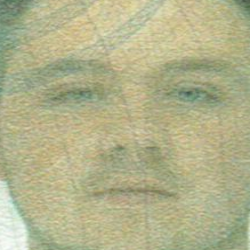

In [ ]:
f = faces[0]
x, y, width, height = f['box']
roi = img[y:y+height, x:x+width]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
roi_a = cv2.resize(roi, (250, 250)) 
cv2_imshow(roi_a)

In [ ]:
org = cv2.cvtColor(cv2.imread("org.jpg"), cv2.COLOR_BGR2RGB)

In [ ]:
faces_org = detector.detect_faces(org)

In [ ]:
faces_org.sort(key=lambda x : x['confidence'] ,reverse=True)

In [ ]:
faces_org

[{'box': [696, 952, 957, 1301],
  'confidence': 0.9999947547912598,
  'keypoints': {'left_eye': (938, 1480),
   'mouth_left': (994, 1979),
   'mouth_right': (1352, 1981),
   'nose': (1169, 1704),
   'right_eye': (1379, 1472)}},
 {'box': [49, -118, 619, 661],
  'confidence': 0.8415143489837646,
  'keypoints': {'left_eye': (453, 80),
   'mouth_left': (401, 276),
   'mouth_right': (503, 320),
   'nose': (573, 172),
   'right_eye': (558, 138)}}]

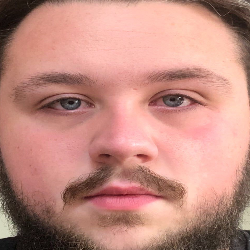

In [ ]:
f = faces_org[0]
x, y, width, height = f['box']
roi = org[y:y+height, x:x+width]
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
roi_b = cv2.resize(roi, (250, 250)) 
cv2_imshow(roi_b )

In [ ]:
img = image.img_to_array(roi_a).astype('uint8')
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

pred = infer_model.predict(x)

In [ ]:
pred

array([[-0.09816048,  0.14464018,  0.1704588 ,  0.00962011,  0.13943703,
        -0.09563027,  0.173818  , -0.04725586,  0.02563296, -0.107278  ,
         0.05921918, -0.00723996, -0.08596681,  0.0531845 ,  0.05203275,
         0.08431533,  0.05214313, -0.07612567,  0.02379467, -0.02555797,
        -0.00348995,  0.09270043,  0.07262781,  0.07838209,  0.01791501,
        -0.067817  ,  0.01207569,  0.01787226, -0.00347056, -0.04700113,
         0.01070395,  0.01739817, -0.09225466,  0.02684948, -0.104043  ,
         0.04301666, -0.05922959, -0.05549469,  0.17909586, -0.03660172,
        -0.07468255,  0.09883451, -0.06258297, -0.07681803, -0.10267445,
         0.18950889, -0.0905662 ,  0.04980819, -0.16484809,  0.02548244,
        -0.08393566,  0.01689506,  0.1874739 , -0.04897448, -0.14680663,
        -0.20626432,  0.01306755,  0.08543795,  0.05111904,  0.07685867,
        -0.10522561, -0.16483036, -0.00093882, -0.01263139,  0.07587713,
        -0.04351643,  0.01853183, -0.0327722 , -0.1

In [ ]:
img = image.img_to_array(roi_b).astype('uint8')
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

pred_b = infer_model.predict(x)

In [ ]:
cosine_similarity(pred,pred_b)

array([[0.97465014]], dtype=float32)